In [ ]:
import meteva.base as meb      # 该模块用于IO和基础计算
import meteva.method as mem    # 该模块基础了检验的基础算法
import meteva.product as mpd   # 该模块包含了检验的工具
import cupy as np          
import datetime                      
import copy
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.pyplot as plt
import salem
%run /mnt/d/work/sunhh/script/function/lambert_ticks

In [2]:
def YMD_todatetime(ds):
  # 读取年月日数据，转换为Timestape，由于本质上还是遍历所有行，因此这个步骤最费时间
    import pandas as pd
    from datetime import datetime
    time = datetime(  # datetime 只接收整形参数，返回一个datetime类型的日期
        ds['Year'].astype(int), ds['Mon'].astype(int), ds['Day'].astype(int), ds['Hour'].astype(int)
    )
    return pd.to_datetime(time)
def PreProcess(df_t):
    df_t.insert( # 插入日期列，此时并不以此为索引
        1, 'time',df_t.iloc[:, 1:5].apply(YMD_todatetime, axis=1)
    ) 
    df_t.drop(columns=['Year', 'Mon', 'Day', 'Hour'], inplace=True, errors='raise')
    return df_t

In [3]:
StaDir = '/mnt/d/work/sunhh/data/station/' # 文件路径，自定义
usecols = ['Station_Id_C', 'Year', 'Mon', 'Day', 'Hour', 'TEM', 'PRE_1h'] # 需要的变量
# na_values = [32700, 32744, 32766]  # 分别代表 微量、空白、缺测，读取时替换为Nan
df = pd.DataFrame() 
df_t = pd.read_csv(
    StaDir+'SURF_CHN_MUL_HOR_20220707-20220810.txt',
    # sep='\s+',  parse_dates=False, na_values=na_values,
    sep='\s+',  parse_dates=False,
    engine='python', usecols=usecols, encoding='utf-8')
df = df_t.loc[(df_t.Mon==7)&(df_t.Day>=24)&(df_t.Day<=27)]
df,type(df)

(         Station_Id_C  Year  Mon  Day  Hour   TEM  PRE_1h
 408             50136  2022    7   24     0  17.2     0.0
 409             50136  2022    7   24     1  21.2     0.0
 410             50136  2022    7   24     2  24.8     0.0
 411             50136  2022    7   24     3  26.5     0.0
 412             50136  2022    7   24     4  26.6     0.0
 ...               ...   ...  ...  ...   ...   ...     ...
 2104885         59951  2022    7   27    19  26.9     0.0
 2104886         59951  2022    7   27    20  26.7     0.0
 2104887         59951  2022    7   27    21  26.1     0.0
 2104888         59951  2022    7   27    22  25.4     0.0
 2104889         59951  2022    7   27    23  25.4     0.0
 
 [487296 rows x 7 columns],
 pandas.core.frame.DataFrame)

In [4]:
station=pd.read_excel('/mnt/d/work/sunhh/data/station/SURF_CHN_LIST.xlsx')
data=pd.merge(df[['Station_Id_C','Year','Mon','Day','Hour','PRE_1h','TEM']],station[['Station_Id_C','Lat','Lon']],on='Station_Id_C')
data=PreProcess(data)
data.insert(loc=0,column="level",value=0)
data.insert(loc=2,column="dtime",value=0)
data.rename(columns={"Station_Id_C":"id", "Lat":"lat","Lon":"lon"},inplace=True)
datalist=["level","time","dtime","id","lon","lat","PRE_1h","TEM"]
data=data[datalist]
data,type(data['time'])

(        level                time  dtime     id       lon      lat  PRE_1h  \
 0           0 2022-07-24 00:00:00      0  50136  122.5108  52.9744     0.0   
 1           0 2022-07-24 01:00:00      0  50136  122.5108  52.9744     0.0   
 2           0 2022-07-24 02:00:00      0  50136  122.5108  52.9744     0.0   
 3           0 2022-07-24 03:00:00      0  50136  122.5108  52.9744     0.0   
 4           0 2022-07-24 04:00:00      0  50136  122.5108  52.9744     0.0   
 ...       ...                 ...    ...    ...       ...      ...     ...   
 487291      0 2022-07-27 19:00:00      0  59951  110.3269  18.8006     0.0   
 487292      0 2022-07-27 20:00:00      0  59951  110.3269  18.8006     0.0   
 487293      0 2022-07-27 21:00:00      0  59951  110.3269  18.8006     0.0   
 487294      0 2022-07-27 22:00:00      0  59951  110.3269  18.8006     0.0   
 487295      0 2022-07-27 23:00:00      0  59951  110.3269  18.8006     0.0   
 
          TEM  
 0       17.2  
 1       21.2  
 2

In [5]:
def nearest_position( stn_lat, stn_lon, lat2d, lon2d):
    """获取最临近格点坐标索引
    stn_lat  : 站点纬度
    stn_lon  : 站点经度
    lat2d    : numpy.ndarray网格二维经度坐标
    lon2d    : numpy.ndarray网格二维纬度坐标
    Return: (y_index, x_index)
    """
    difflat = stn_lat - lat2d;
    difflon = stn_lon - lon2d;
    rad = np.multiply(difflat,difflat)+np.multiply(difflon , difflon)
    aa=np.where(rad==np.min(rad))
    ind=np.squeeze(np.array(aa))
    return tuple(ind)

In [70]:
def wrf2sta(sta_lon,sta_lat,sta_id,wrfout):
    lat2d       = wrfout.lat
    lon2d       = wrfout.lon
    times       = wrfout.time
    nt     = len(times)
    ny, nx = np.shape(lat2d)
    sta_id_tmp,time_tmp,lat_tmp,lon_tmp,pcp_tmp,tem_tmp = [],[],[],[],[],[]
    for lon_sta,lat_sta,id_sta in zip(sta_lon,sta_lat,sta_id):
        index_sta = nearest_position(lat_sta, lon_sta, lon2d, lat2d)
        j_sta = index_sta[0]
        i_sta = index_sta[1]
        precipitation = wrfout.RAINC.values + wrfout.RAINNC.values + wrfout.RAINSH.values
        T2  = wrfout.T2.values
        # pcp_temp = []
        for it in range(nt):
            pcp_sta = precipitation[it, j_sta, i_sta]
            tem_sta = T2[it,j_sta,i_sta]-273.15
            sta_id_tmp.append(id_sta)
            time_tmp.append(times[it].values)
            lon_tmp.append(lon_sta)
            lat_tmp.append(lat_sta)
            pcp_tmp.append(pcp_sta)
            tem_tmp.append(tem_sta)
    all_list = list(zip(sta_id_tmp,time_tmp,lon_tmp,lat_tmp,pcp_tmp,tem_tmp))
    dframe = pd.DataFrame(all_list, columns=["id","time","lon","lat","pre_1h","tem_1h"])
    return dframe

In [118]:
datadir="/mnt/d/work/sunhh/data/run2/"
wrf_list = ["1","1.1","1.2","1.3"]
# wrf_list = ["1.1"]
wrf_all = []
for wrf_mem in wrf_list:
    wrfout = salem.open_wrf_dataset(datadir+f"{wrf_mem}/wrfout_d02_2022-07-25_00_00_00")
    sta_wrf = wrf2sta(station.Lon,station.Lat,station.Station_Id_C,wrfout)
    wrf_all.append(sta_wrf)

In [121]:
wrf_10,wrf_11,wrf_12,wrf_13=wrf_all[0],wrf_all[1],wrf_all[2],wrf_all[3]
wrf_10,wrf_11,wrf_12,wrf_13

(           id                time       lon      lat  pre_1h     tem_1h
 0       54433 2022-07-25 00:00:00  116.5008  39.9525     0.0  20.288232
 1       54433 2022-07-25 01:00:00  116.5008  39.9525     0.0  23.241571
 2       54433 2022-07-25 02:00:00  116.5008  39.9525     0.0  25.190607
 3       54433 2022-07-25 03:00:00  116.5008  39.9525     0.0  26.882288
 4       54433 2022-07-25 04:00:00  116.5008  39.9525     0.0  28.294885
 ...       ...                 ...       ...      ...     ...        ...
 106178  51053 2022-07-26 20:00:00   86.4058  48.0517     0.0  19.678796
 106179  51053 2022-07-26 21:00:00   86.4058  48.0517     0.0  19.223779
 106180  51053 2022-07-26 22:00:00   86.4058  48.0517     0.0  19.430566
 106181  51053 2022-07-26 23:00:00   86.4058  48.0517     0.0  18.369897
 106182  51053 2022-07-27 00:00:00   86.4058  48.0517     0.0  18.994989
 
 [106183 rows x 6 columns],
            id                time       lon      lat    pre_1h     tem_1h
 0       54433 2022

In [122]:
def prep_clf(obs,pre, threshold=0.1):
    '''
    func: 计算二分类结果-混淆矩阵的四个元素
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        hits, misses, falsealarms, correctnegatives
        #aliases: TP, FN, FP, TN 
    '''
    #根据阈值分类为 0, 1
    obs = np.where(obs >= threshold, 1, 0)
    pre = np.where(pre >= threshold, 1, 0)
    # True positive (TP)
    hits = np.sum((obs == 1) & (pre == 1))
    # False negative (FN)
    misses = np.sum((obs == 1) & (pre == 0))
    # False positive (FP)
    falsealarms = np.sum((obs == 0) & (pre == 1))
    # True negative (TN)
    correctnegatives = np.sum((obs == 0) & (pre == 0))
    return hits, misses, falsealarms, correctnegatives
def precision(obs, pre, threshold=0.1):
    '''
    func: 计算精确度precision: TP / (TP + FP)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。   
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return TP / (TP + FP)
def recall(obs, pre, threshold=0.1):
    '''
    func: 计算召回率recall: TP / (TP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return TP / (TP + FN)
def ACC(obs, pre, threshold=0.1):
    '''
    func: 计算准确度Accuracy: (TP + TN) / (TP + TN + FP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return (TP + TN) / (TP + TN + FP + FN)
def FSC(obs, pre, threshold=0.1):
    '''
    func:计算f1 score = 2 * ((precision * recall) / (precision + recall))
    '''
    precision_socre = precision(obs, pre, threshold=threshold)
    recall_score = recall(obs, pre, threshold=threshold)
    return 2 * ((precision_socre * recall_score) / (precision_socre + recall_score))

In [123]:
#TS 评分
def TS(obs, pre, threshold=0.1):
    '''
    func: 计算TS评分: TS = hits/(hits + falsealarms + misses) 
    	  alias: TP/(TP+FP+FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''
    hits, misses, falsealarms, correctnegatives = prep_clf(obs=obs, pre = pre, threshold=threshold)
    return hits/(hits + falsealarms + misses) 

In [128]:
wrf_obs = pd.merge(wrf_all[0],station[["id","PRE_1h","TEM"]],on='id')

KeyError: "None of [Index(['id', 'PRE_1h', 'TEM'], dtype='object')] are in the [columns]"

In [ ]:
TS_10 = TS()

In [6]:
datadir="/mnt/d/work/sunhh/data/run2/"
wrfout      = salem.open_wrf_dataset(datadir+"1/wrfout_d02_2022-07-25_00_00_00")
lat2d       = wrfout.lat
lon2d       = wrfout.lon
times       = wrfout.time
nt     = len(times)
ny, nx = np.shape(lat2d)

In [22]:
sta_id,time,lat,lon,pcp,tem = [],[],[],[],[],[]
for lon_sta,lat_sta,id_sta in zip(station.Lon,station.Lat,station.Station_Id_C):
    index_sta = nearest_position(lat_sta, lon_sta, lat2d, lon2d)
    j_sta = index_sta[0]
    i_sta = index_sta[1]
    precipitation = wrfout.RAINC.values + wrfout.RAINNC.values + wrfout.RAINSH.values
    T2  = wrfout.T2.values
    # pcp_temp = []
    for it in range(nt):
        pcp_sta = precipitation[it, j_sta, i_sta]
        tem_sta = T2[it,j_sta,i_sta]-273.15
        sta_id.append(id_sta)
        time.append(times[it].values)
        lon.append(lon_sta)
        lat.append(lat_sta)
        pcp.append(pcp_sta)
        tem.append(tem_sta)
#         pcp_temp.append(np.expand_dims(pcp_sta,axis=0))
#     pcp_temp = np.concatenate(pcp_temp,axis=0)
#     pcp_a.append(np.expand_dims(pcp_temp,axis=0))
# pcp_a = np.concatenate(pcp_a,axis=0)

In [23]:
len(sta_id),len(time),len(lon),len(lat),len(pcp),len(tem)
all_list = list(zip(sta_id,time,lon,lat,pcp,tem))
dframe = pd.DataFrame(all_list, columns=["id","time","lon","lat","pcp","tem"])
draw_data = dframe[dframe['time']=='2022-07-25T03']
draw_data

,id,time,lon,lat,pcp,tem
3,54433,2022-07-25 03:00:00,116.5008,39.9525,0.0,31.281824
52,54514,2022-07-25 03:00:00,116.2453,39.8703,0.0,31.200403
101,54513,2022-07-25 03:00:00,116.2053,39.9425,0.0,31.200403
150,54399,2022-07-25 03:00:00,116.2908,39.9869,0.0,31.187402
199,54501,2022-07-25 03:00:00,115.6917,39.9742,0.0,31.402551
...,...,...,...,...,...,...
105941,51060,2022-07-25 03:00:00,86.8683,47.7094,0.0,26.882288
105990,51087,2022-07-25 03:00:00,89.4931,47.0097,0.0,26.882288
106039,51058,2022-07-25 03:00:00,87.9722,47.1025,0.0,26.882288
106088,51068,2022-07-25 03:00:00,87.4814,47.1250,0.0,26.882288


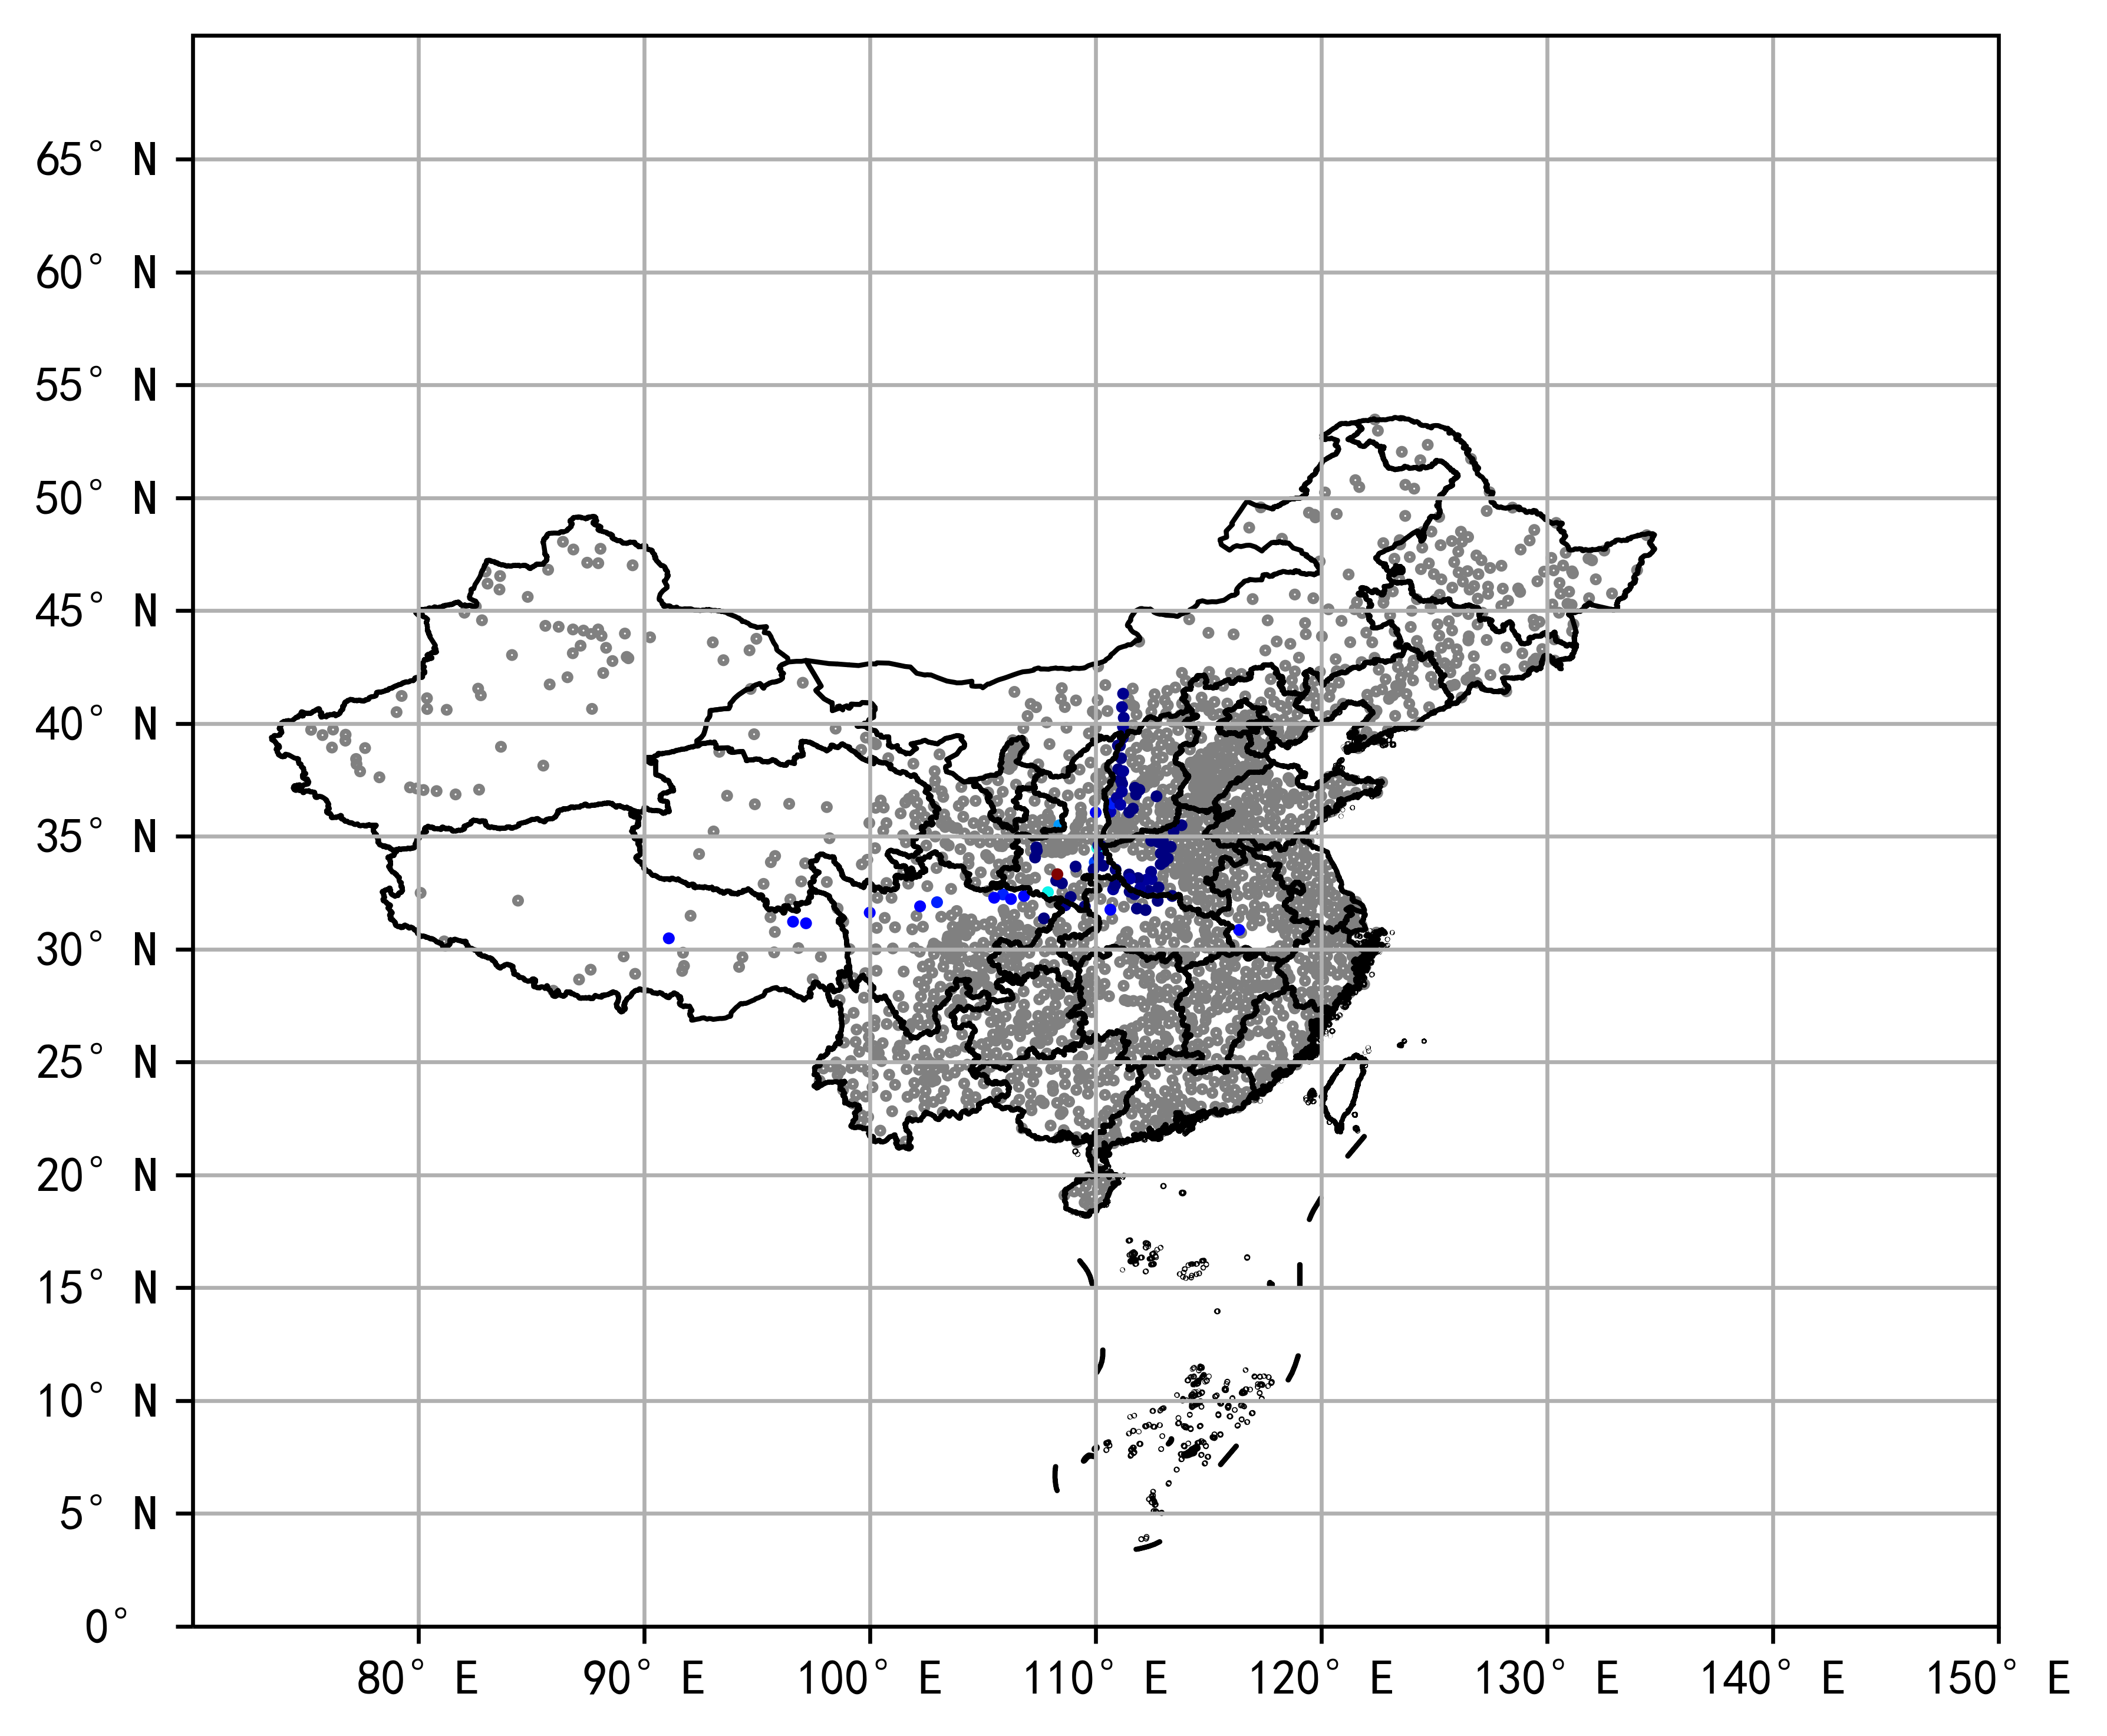

In [26]:
##画图
# proj = ccrs.LambertConformal(central_longitude=118, central_latitude=37,
#                             standard_parallels=(30, 60))
proj = ccrs.PlateCarree(central_longitude=110)
#读取中国省界shp文件
cnmap="/mnt/d/work/sunhh/script/map/cn_shp/Province_9south/province_9south.shp"
reader = shpreader.Reader(cnmap)
states_provinces = cfeature.ShapelyFeature(reader.geometries(), crs = ccrs.PlateCarree(), edgecolor = 'face', facecolor = 'None')

fig = plt.figure(figsize=(15,15), frameon=True, dpi=600, facecolor='white')
ax1 = fig.add_axes([0.6,0.44,0.6,0.3],projection=proj)
# ax2 = fig.add_axes([1.14,0.44,0.6,0.3],projection=proj)
# ax3 = fig.add_axes([1.68,0.44,0.6,0.3],projection=proj)
# ax4 = fig.add_axes([1.64,0.44,0.6,0.3],projection=proj)
# axlist = [ax1,ax2,ax3]
axlist=[ax1]
for axs in axlist:
    #画图区域
    # axs.set_extent([102, 133, 25, 45], crs=ccrs.PlateCarree())
    axs.set_extent([70,150,0,70.5], crs=ccrs.PlateCarree())
    # ax.coastlines(resolution='50m')
    axs.add_feature(states_provinces, edgecolor='black')
    # 必须调用draw来获得用于添加刻度的轴边界:
    fig.canvas.draw()
    # 定义网格线位置，并使用cartopy的内置网格线绘制线条:
    xticks = list(range(60, 176, 10))
    yticks = list(range(-5, 66, 5))
    axs.gridlines(xlocs=xticks, ylocs=yticks)
    # 使用自定义的标记符标记网格线的端点:
    axs.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    axs.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    # xticks and yticks only is list
    lambert_xticks(axs, xticks)  
    lambert_yticks(axs, yticks)
    
ax1.scatter(draw_data.lon[draw_data.pcp==0],draw_data.lat[draw_data.pcp==0],c='',zorder=0,s=2,marker='o',edgecolors='gray',transform=ccrs.PlateCarree())
ax1.scatter(draw_data.lon[draw_data.pcp>0],draw_data.lat[draw_data.pcp>0],c=draw_data.pcp[draw_data.pcp!=0],zorder=1,s=2,cmap='jet',transform=ccrs.PlateCarree())
# fig.savefig('/mnt/d/work/sunhh/figure/obs/ERA_T.png',dpi=600,bbox_inches='tight')

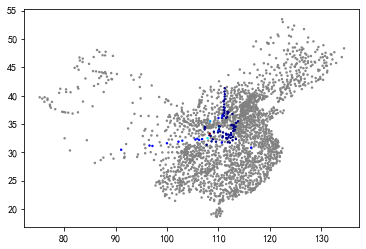

In [25]:
plt.scatter(draw_data.lon[draw_data.pcp==0],draw_data.lat[draw_data.pcp==0],c='',zorder=0,s=2,marker='o',edgecolors='gray')
plt.scatter(draw_data.lon[draw_data.pcp!=0],draw_data.lat[draw_data.pcp!=0],c=draw_data.pcp[draw_data.pcp!=0],zorder=1,s=2,cmap='jet')

In [21]:
draw_data.lon,draw_data.lat

(3         39.9525
 52        39.8703
 101       39.9425
 150       39.9869
 199       39.9742
            ...   
 105941    47.7094
 105990    47.0097
 106039    47.1025
 106088    47.1250
 106137    48.0517
 Name: lon, Length: 2167, dtype: float64,
 3         116.5008
 52        116.2453
 101       116.2053
 150       116.2908
 199       115.6917
             ...   
 105941     86.8683
 105990     89.4931
 106039     87.9722
 106088     87.4814
 106137     86.4058
 Name: lat, Length: 2167, dtype: float64)

In [14]:
obs_data = data[data['time']=='2022-07-25T03']
obs_data,draw_data

(        level                time  dtime     id       lon      lat  PRE_1h  \
 155         0 2022-07-25 03:00:00      0  50136  122.5108  52.9744     0.0   
 379         0 2022-07-25 03:00:00      0  50137  122.3783  53.4692     0.0   
 604         0 2022-07-25 03:00:00      0  50246  124.7183  52.3481     0.0   
 829         0 2022-07-25 03:00:00      0  50247  123.5722  52.0361     0.0   
 1054        0 2022-07-25 03:00:00      0  50349  124.3917  51.6650     0.0   
 ...       ...                 ...    ...    ...       ...      ...     ...   
 486327      0 2022-07-25 03:00:00      0  59855  110.4819  19.2089     0.0   
 486552      0 2022-07-25 03:00:00      0  59856  110.7453  19.6139     0.0   
 486777      0 2022-07-25 03:00:00      0  59941  109.5178  18.7739     0.0   
 487002      0 2022-07-25 03:00:00      0  59945  109.6967  18.6433     0.0   
 487227      0 2022-07-25 03:00:00      0  59951  110.3269  18.8006     0.0   
 
          TEM  
 155     26.9  
 379     27.2  
 6

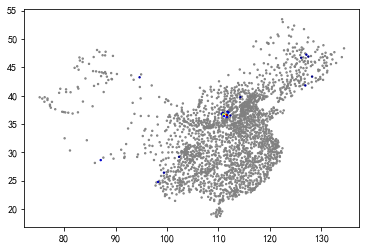

In [15]:
plt.scatter(obs_data.lon[data.PRE_1h==0],obs_data.lat[data.PRE_1h==0],c='',zorder=0,s=2,marker='o',edgecolors='gray')
plt.scatter(obs_data.lon[data.PRE_1h!=0],obs_data.lat[data.PRE_1h!=0],c=obs_data.PRE_1h[data.PRE_1h!=0],zorder=1,s=2,cmap='jet')

In [36]:
data_wrf=draw_data[(draw_data.lon>=107) & (draw_data.lon<=117) & (draw_data.lat>=29) & (draw_data.lat<=38)]
data_obs=obs_data[(obs_data.lon>=107) & (obs_data.lon<=117) & (obs_data.lat>=29) & (obs_data.lat<=38)]
data_wrf

,id,time,lon,lat,pcp,tem
1522,53789,2022-07-25 03:00:00,114.6333,37.8833,0.000000,31.680139
1767,53790,2022-07-25 03:00:00,114.6078,37.6347,0.000000,31.680139
1865,53795,2022-07-25 03:00:00,114.4058,37.6581,0.000000,31.175104
2012,53791,2022-07-25 03:00:00,114.4997,37.8067,0.000000,31.533472
2061,53784,2022-07-25 03:00:00,114.7833,37.7500,0.000000,31.686212
...,...,...,...,...,...,...
98248,53935,2022-07-25 03:00:00,108.3986,35.4897,2.810761,25.791132
98297,53937,2022-07-25 03:00:00,107.8911,35.5317,0.000000,28.345148
98346,53925,2022-07-25 03:00:00,107.2122,35.7206,0.000000,27.892145
102266,53723,2022-07-25 03:00:00,107.2439,37.7925,0.000000,27.145197


In [42]:
data_obs

,level,time,dtime,id,lon,lat,PRE_1h,TEM
71221,0,2022-07-25 03:00:00,0,53659,111.0050,37.9706,0.0,25.9
73696,0,2022-07-25 03:00:00,0,53677,112.4767,37.9375,0.0,27.9
74146,0,2022-07-25 03:00:00,0,53679,112.5442,37.7475,0.0,28.7
75271,0,2022-07-25 03:00:00,0,53687,113.6314,37.7869,0.0,27.8
78645,0,2022-07-25 03:00:00,0,53723,107.2439,37.7925,0.0,28.1
...,...,...,...,...,...,...,...,...
411555,0,2022-07-25 03:00:00,0,58509,115.8131,29.0331,0.0,34.3
411780,0,2022-07-25 03:00:00,0,58510,116.2078,29.6881,0.0,34.2
412005,0,2022-07-25 03:00:00,0,58512,116.5447,29.8933,0.0,34.7
412230,0,2022-07-25 03:00:00,0,58514,116.0342,29.4469,0.0,33.5


In [48]:
final = pd.merge(data_wrf,data_obs[["id","PRE_1h","TEM"]],on='id')

,id,time,lon,lat,pcp,tem,PRE_1h,TEM
0,53789,2022-07-25 03:00:00,114.6333,37.8833,0.000000,31.680139,0.0,29.8
1,53790,2022-07-25 03:00:00,114.6078,37.6347,0.000000,31.680139,0.0,29.5
2,53795,2022-07-25 03:00:00,114.4058,37.6581,0.000000,31.175104,0.0,28.6
3,53791,2022-07-25 03:00:00,114.4997,37.8067,0.000000,31.533472,0.0,29.3
4,53784,2022-07-25 03:00:00,114.7833,37.7500,0.000000,31.686212,0.0,30.0
...,...,...,...,...,...,...,...,...
510,53935,2022-07-25 03:00:00,108.3986,35.4897,2.810761,25.791132,0.0,24.8
511,53937,2022-07-25 03:00:00,107.8911,35.5317,0.000000,28.345148,0.0,26.3
512,53925,2022-07-25 03:00:00,107.2122,35.7206,0.000000,27.892145,0.0,24.5
513,53723,2022-07-25 03:00:00,107.2439,37.7925,0.000000,27.145197,0.0,28.1


In [52]:
final['pcp'].mean(),final['PRE_1h'].mean()

(0.06072973, 0.09262135922330098)